In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow import keras

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
!nvidia-smi

Wed Sep  1 10:45:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    57W / 149W |    121MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from keras import layers
from keras import Input
from keras import optimizers
from keras.models import Model
from keras.layers import Dropout, Flatten, Conv1D,LSTM,Bidirectional
import random

In [6]:
from sklearn.preprocessing import StandardScaler
from platform import python_version
from keras.constraints import maxnorm

In [7]:
data = pd.read_csv("/content/drive/MyDrive/techniche/train.csv")
test = pd.read_csv("/content/drive/MyDrive/techniche/test.csv")

In [8]:
def one_hot_encoder(df, features):
    dummies = pd.get_dummies(df[features], drop_first=True)
    res = pd.concat([df, dummies], axis=1)
    res = res.drop(features, axis=1)
    return(res)

In [9]:
categorical_cols = list(data.select_dtypes(include=["object"]).columns)
data_onehot = one_hot_encoder(data, categorical_cols)
test_onehot = one_hot_encoder(test, categorical_cols)

In [10]:
cols_train = list(data_onehot.columns[:25]) + ['CATEGORY_1_D', 'CATEGORY_1_E'] + list(data_onehot.columns[25:])
cols_train
data_onehot['CATEGORY_1_D']=0
data_onehot['CATEGORY_1_E']=0
data_onehot = data_onehot[cols_train]
data_onehot.head()

,UNIQUE_IDENTIFIER,SEQUENCE_NO,STATUS_CHECK,ACTIVE_YN,ENTRY,REVENUE,WINNINGS_1,WINNINGS_2,DISCOUNT,DEPOSIT,DEPOSIT_NUMBER,DEPOSIT_2,WITHDRAW,WITHDRAW_NUMBER,DEPOSIT_TRAILS,ENTRY_NUMBER,WINNINGS_NUMBER,PRACTICE_ENTRY,PRACTICE_WINNINGS,PRACTICE_ENTRY_NUMBER,PRACTICE_WINNINGS_NUMBER,Y1,Y2,CATEGORY_1_B,CATEGORY_1_C,CATEGORY_1_D,CATEGORY_1_E,CATEGORY_1_F,CATEGORY_1_G,CATEGORY_1_I,CATEGORY_1_J,CATEGORY_1_K,CATEGORY_1_L,CATEGORY_1_M,CATEGORY_2_B,CATEGORY_2_C,CATEGORY_2_D,CATEGORY_2_E,CATEGORY_2_F,CATEGORY_2_G,CATEGORY_2_H,CATEGORY_2_I
0,98481267304,1,0,1,0.00000,0.000000,0.0000,0.0,0.0,0.25,0.1,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.449287,101.369863,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
1,98481267304,2,0,1,0.13735,0.011550,0.0999,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,1.8,1.0,0.0,0.0,0.0,0.0,4.449287,101.369863,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
2,98481267304,3,0,1,0.15835,0.010425,0.0242,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.7,0.3,0.0,0.0,0.0,0.0,4.449287,101.369863,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,98481267304,4,0,1,0.44490,0.035850,0.2398,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,2.8,1.5,0.0,0.0,0.0,0.0,4.449287,101.369863,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
4,98481267304,5,0,1,0.00000,0.000000,0.0000,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.449287,101.369863,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0


In [11]:
Y_train = data_onehot.groupby('UNIQUE_IDENTIFIER').mean()[['Y1', 'Y2']]
Y_train.head()

,Y1,Y2
UNIQUE_IDENTIFIER,,
98481267304,4.449287,101.369863
98481267698,7.182779,115.068493
98481269325,3.977371,24.657534
98481271512,3.988122,10.958904
98481273023,4.128875,46.575342


In [12]:
X_train = data_onehot.drop(["Y1", "Y2"], axis=1)
X_train.head()

,UNIQUE_IDENTIFIER,SEQUENCE_NO,STATUS_CHECK,ACTIVE_YN,ENTRY,REVENUE,WINNINGS_1,WINNINGS_2,DISCOUNT,DEPOSIT,DEPOSIT_NUMBER,DEPOSIT_2,WITHDRAW,WITHDRAW_NUMBER,DEPOSIT_TRAILS,ENTRY_NUMBER,WINNINGS_NUMBER,PRACTICE_ENTRY,PRACTICE_WINNINGS,PRACTICE_ENTRY_NUMBER,PRACTICE_WINNINGS_NUMBER,CATEGORY_1_B,CATEGORY_1_C,CATEGORY_1_D,CATEGORY_1_E,CATEGORY_1_F,CATEGORY_1_G,CATEGORY_1_I,CATEGORY_1_J,CATEGORY_1_K,CATEGORY_1_L,CATEGORY_1_M,CATEGORY_2_B,CATEGORY_2_C,CATEGORY_2_D,CATEGORY_2_E,CATEGORY_2_F,CATEGORY_2_G,CATEGORY_2_H,CATEGORY_2_I
0,98481267304,1,0,1,0.00000,0.000000,0.0000,0.0,0.0,0.25,0.1,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
1,98481267304,2,0,1,0.13735,0.011550,0.0999,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,1.8,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
2,98481267304,3,0,1,0.15835,0.010425,0.0242,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.7,0.3,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,98481267304,4,0,1,0.44490,0.035850,0.2398,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,2.8,1.5,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
4,98481267304,5,0,1,0.00000,0.000000,0.0000,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0


In [13]:
def input_generator(df_input):
    
    customer_stamp = df_input['UNIQUE_IDENTIFIER'].value_counts()
    customer_id = df_input['UNIQUE_IDENTIFIER'].unique()
    n_customer_stamp = customer_stamp[customer_id].values
    cumsum_customer_stamp = np.cumsum(n_customer_stamp, axis=0)
    time_stamp = np.hstack((0, cumsum_customer_stamp))
    row_size = np.max(n_customer_stamp)
    input_array = np.ones((customer_id.shape[0], row_size, df_input.shape[1]))*(-1)
    
    for i in range(time_stamp.shape[0]-1):
        temp_array = df_input.iloc[time_stamp[i]:time_stamp[i+1], :].values
        input_array[i, :, :] = np.pad(temp_array, ((0, row_size-temp_array.shape[0]), (0, 0)), mode='constant', constant_values=(-1, 0))
    
    return input_array

In [14]:
scaler2 = StandardScaler()
X2_train_scaled = pd.DataFrame(scaler2.fit_transform(X_train), columns=X_train.columns)
X2_test_scaled = pd.DataFrame(scaler2.transform(test_onehot), columns=test_onehot.columns)

In [15]:
X2_train = input_generator(X2_train_scaled)

In [16]:
X2_test = input_generator(X2_test_scaled)

In [17]:
X2_train = X2_train[:, :, 1:]
X2_test = X2_test[:, :, 1:]

In [18]:
print(X2_train.shape)
print(X2_test.shape)

(96298, 30, 39)
(65242, 30, 39)


# DL Model

CONV1D + BI-LSTM


In [19]:

input_ = tfl.Input(shape=(X2_train.shape[1], X2_train.shape[2]))
print(input_.shape)

#1st layer
x = tfl.Conv1D(filters=16, kernel_size=3,padding = 'same')(input_)
x = tfl.ReLU()(x)
#x = tfl.BatchNormalization()(x)
x = tfl.MaxPool1D(1)(x)

#2nd layer
x = tfl.Conv1D(filters=32, kernel_size=3, padding = 'same')(x)
x = tfl.ReLU()(x)
#x = tfl.BatchNormalization()(x)
x = tfl.MaxPool1D(1)(x)

#3nd layer
#x = tfl.Conv1D(filters=64, kernel_size=3, padding = 'same')(x)
#x = tfl.ReLU()(x)
#x = tfl.BatchNormalization()(x)
#x = tfl.MaxPool1D(1)(x)

print(x.shape)

x=tfl.Bidirectional(tfl.LSTM(64, input_shape=(x.shape[1], x.shape[2])))(x)

print(x.shape)

#3rd layer
#x = tfl.Flatten()(x)
#print(x.shape)
#x = tfl.Dense(450,activation='selu',kernel_initializer='he_uniform',kernel_constraint=maxnorm(5))(x)
#x = tfl.Dropout(0.7)(x)
#x = tfl.ELU(alpha=1)(x)
x = tfl.Dense(200,activation='selu',kernel_constraint=maxnorm(5))(x)
x = tfl.Dropout(0.8)(x)
#x = tfl.ELU(alpha=1)(x)
x = tfl.Dense(20,activation='selu',kernel_constraint=maxnorm(5))(x)
x = tfl.Dropout(0.5)(x)
#x = tfl.ELU(alpha=1)(x)
output = tfl.Dense(1)(x)

model = tf.keras.Model(inputs=input_, outputs=output)


(None, 30, 39)
(None, 30, 32)
(None, 128)


CONV2D + BI-LSTM

In [ ]:
'''
input_ = tfl.Input(shape=(X2_train.shape[1], X2_train.shape[2]))
print(input_.shape)

x=tf.keras.layers.Reshape((X2_train.shape[1], X2_train.shape[2],1), input_shape=(X2_train.shape[1], X2_train.shape[2]))(input_)
print(x.shape)
#1st layer
x = tfl.Conv2D(filters=16, kernel_size=3,padding = 'same')(x)
x = tfl.ReLU()(x)
#x = tfl.BatchNormalization()(x)
#x = tfl.MaxPool2D(2)(x)
print(x.shape)

#2nd layer
x = tfl.Conv2D(filters=32, kernel_size=3, padding = 'same')(x)
x = tfl.ReLU()(x)
#x = tfl.BatchNormalization()(x)
#x = tfl.MaxPool2D(2)(x)
print(x.shape)
x = tfl.Reshape([x.shape[1],x.shape[2]*x.shape[3]])(x)
print(x.shape)
x=tfl.Bidirectional(tfl.LSTM(256, return_sequences=True), input_shape=(x.shape[1], x.shape[2]))(x)

print(x.shape)
#3rd layer
x = tfl.Flatten()(x)
print(x.shape)
x = tfl.Dense(1500,activation='selu',kernel_initializer='he_uniform',kernel_constraint=maxnorm(5))(x)
x = tfl.Dropout(0.5)(x)
#x = tfl.ELU(alpha=1)(x)
x = tfl.Dense(800,activation='selu',kernel_constraint=maxnorm(5))(x)
x = tfl.Dropout(0.5)(x)
#x = tfl.ELU(alpha=1)(x)
print(x.shape)
x = tfl.Dense(400,activation='selu',kernel_constraint=maxnorm(5))(x)
x = tfl.Dropout(0.5)(x)
x = tfl.Dense(100,activation='selu',kernel_constraint=maxnorm(5))(x)
x = tfl.Dropout(0.5)(x)
x = tfl.Dense(50,activation='selu',kernel_constraint=maxnorm(5))(x)
x = tfl.Dropout(0.5)(x)
print(x.shape)
#x = tfl.ELU(alpha=1)(x)
output = tfl.Dense(1)(x)

model = tf.keras.Model(inputs=input_, outputs=output)
'''

(None, 30, 39)
(None, 30, 39, 1)
(None, 30, 39, 16)
(None, 30, 39, 32)
(None, 30, 1248)
(None, 30, 512)
(None, 15360)
(None, 800)
(None, 50)


201 MSE AND REAL SCORE OF 72

In [ ]:
# After 40 epochs this was over fitting
'''
input_ = tfl.Input(shape=(X2_train.shape[1], X2_train.shape[2]))
print(input_.shape)

x=tf.keras.layers.Reshape((X2_train.shape[1], X2_train.shape[2],1), input_shape=(X2_train.shape[1], X2_train.shape[2]))(input_)
print(x.shape)
#1st layer
x = tfl.Conv2D(filters=8, kernel_size=3,padding = 'same')(x)
x = tfl.ReLU()(x)
#x = tfl.BatchNormalization()(x)
#x = tfl.MaxPool2D(2)(x)
print(x.shape)

#2nd layer
x = tfl.Conv2D(filters=16, kernel_size=3, padding = 'same')(x)
x = tfl.ReLU()(x)
#x = tfl.BatchNormalization()(x)
#x = tfl.MaxPool2D(2)(x)
print(x.shape)
x = tfl.Reshape([x.shape[1],x.shape[2]*x.shape[3]])(x)
print(x.shape)
x=tfl.Bidirectional(tfl.LSTM(64, return_sequences=True), input_shape=(x.shape[1], x.shape[2]))(x)

print(x.shape)
#3rd layer
x = tfl.Flatten()(x)
print(x.shape)
x = tfl.Dense(1000,activation='selu',kernel_initializer='he_uniform',kernel_constraint=maxnorm(5))(x)
x = tfl.Dropout(0.5)(x)
#x = tfl.ELU(alpha=1)(x)
x = tfl.Dense(500,activation='selu',kernel_constraint=maxnorm(5))(x)
x = tfl.Dropout(0.5)(x)
#x = tfl.ELU(alpha=1)(x)
print(x.shape)
x = tfl.Dense(200,activation='selu',kernel_constraint=maxnorm(5))(x)
x = tfl.Dropout(0.5)(x)
x = tfl.Dense(50,activation='selu',kernel_constraint=maxnorm(5))(x)
x = tfl.Dropout(0.5)(x)
print(x.shape)
#x = tfl.ELU(alpha=1)(x)
output = tfl.Dense(1)(x)

model = tf.keras.Model(inputs=input_, outputs=output)
'''

"\ninput_ = tfl.Input(shape=(X2_train.shape[1], X2_train.shape[2]))\nprint(input_.shape)\n\nx=tf.keras.layers.Reshape((X2_train.shape[1], X2_train.shape[2],1), input_shape=(X2_train.shape[1], X2_train.shape[2]))(input_)\nprint(x.shape)\n#1st layer\nx = tfl.Conv2D(filters=8, kernel_size=3,padding = 'same')(x)\nx = tfl.ReLU()(x)\n#x = tfl.BatchNormalization()(x)\n#x = tfl.MaxPool2D(2)(x)\nprint(x.shape)\n\n#2nd layer\nx = tfl.Conv2D(filters=16, kernel_size=3, padding = 'same')(x)\nx = tfl.ReLU()(x)\n#x = tfl.BatchNormalization()(x)\n#x = tfl.MaxPool2D(2)(x)\nprint(x.shape)\nx = tfl.Reshape([x.shape[1],x.shape[2]*x.shape[3]])(x)\nprint(x.shape)\nx=tfl.Bidirectional(tfl.LSTM(64, return_sequences=True), input_shape=(x.shape[1], x.shape[2]))(x)\n\nprint(x.shape)\n#3rd layer\nx = tfl.Flatten()(x)\nprint(x.shape)\nx = tfl.Dense(1000,activation='selu',kernel_initializer='he_uniform',kernel_constraint=maxnorm(5))(x)\nx = tfl.Dropout(0.5)(x)\n#x = tfl.ELU(alpha=1)(x)\nx = tfl.Dense(500,activation

1D-CONVNET + BI-LSTM , gave MSE=193

In [ ]:
'''
def conv1D_full(inputs):
    

    inputs=tf.expand_dims(inputs,axis=-1)
    #print(inputs.shape)
    x = Conv1D(filters=8, kernel_size=3, activation='selu', padding='same')(inputs)
    x = Conv1D(filters=16, kernel_size=3, activation='selu', padding='same')(x)
    #print(x.shape)
    #x = layers.MaxPooling1D(2)(x)
   # x = Conv1D(filters=32, kernel_size=3, activation='selu', padding='same')(x)
   # x = Conv1D(filters=64, kernel_size=3, activation='selu', padding='same')(x)
   # x = layers.MaxPooling1D(2)(x)
    #x = layers.Flatten()(x)
    #x = layers.Dense(200, activation='selu')(x)
    #print(x.shape)
    
    return x
'''

"\ndef conv1D_full(inputs):\n    \n\n    inputs=tf.expand_dims(inputs,axis=-1)\n    #print(inputs.shape)\n    x = Conv1D(filters=8, kernel_size=3, activation='selu', padding='same')(inputs)\n    x = Conv1D(filters=16, kernel_size=3, activation='selu', padding='same')(x)\n    #print(x.shape)\n    #x = layers.MaxPooling1D(2)(x)\n   # x = Conv1D(filters=32, kernel_size=3, activation='selu', padding='same')(x)\n   # x = Conv1D(filters=64, kernel_size=3, activation='selu', padding='same')(x)\n   # x = layers.MaxPooling1D(2)(x)\n    #x = layers.Flatten()(x)\n    #x = layers.Dense(200, activation='selu')(x)\n    #print(x.shape)\n    \n    return x\n"

In [ ]:
'''
def multiple_cnn1D(nb):
    
    inputs = Input(shape=(30, nb))

    outputs = conv1D_full(inputs[:,:,0])
    
    for i in range(1,nb):
        x_i = conv1D_full(inputs[:,:,i])
        outputs = tf.concat([ outputs , x_i ] , 2 )
    #print(outputs.shape)
    
    x=Bidirectional(LSTM(64, return_sequences=True), input_shape=(outputs.shape[1],outputs.shape[2]))(outputs)
    #print(x.shape)
    x = Dropout(0.5)(x)
    x = layers.Flatten()(x)
    #print(x.shape)
    x = layers.Dense(1000, activation='selu',kernel_initializer='he_uniform',kernel_constraint=maxnorm(5))(x)
    x =  Dropout(0.5)(x)
    x = layers.Dense(500, activation='selu',kernel_constraint=maxnorm(5))(x)
    x =  Dropout(0.5)(x)
    x = layers.Dense(100,activation='selu',kernel_constraint=maxnorm(5))(x)
    x = Dropout(0.5)(x)
    x = layers.Dense(20,activation='selu',kernel_constraint=maxnorm(5))(x)
    x = Dropout(0.5)(x)
    answer = layers.Dense(1)(x)
    
    #print(answer.shape)
    
    model = Model(inputs, answer)
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=opt, metrics=[tf.keras.metrics.MeanSquaredError()])
    print(model.summary())
    
    #dot_img_file = 'model_LSTM.png'
    #tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, rankdir='LR')
    
    return model
'''

"\ndef multiple_cnn1D(nb):\n    \n    inputs = Input(shape=(30, nb))\n\n    outputs = conv1D_full(inputs[:,:,0])\n    \n    for i in range(1,nb):\n        x_i = conv1D_full(inputs[:,:,i])\n        outputs = tf.concat([ outputs , x_i ] , 2 )\n    #print(outputs.shape)\n    \n    x=Bidirectional(LSTM(64, return_sequences=True), input_shape=(outputs.shape[1],outputs.shape[2]))(outputs)\n    #print(x.shape)\n    x = Dropout(0.5)(x)\n    x = layers.Flatten()(x)\n    #print(x.shape)\n    x = layers.Dense(1000, activation='selu',kernel_initializer='he_uniform',kernel_constraint=maxnorm(5))(x)\n    x =  Dropout(0.5)(x)\n    x = layers.Dense(500, activation='selu',kernel_constraint=maxnorm(5))(x)\n    x =  Dropout(0.5)(x)\n    x = layers.Dense(100,activation='selu',kernel_constraint=maxnorm(5))(x)\n    x = Dropout(0.5)(x)\n    x = layers.Dense(20,activation='selu',kernel_constraint=maxnorm(5))(x)\n    x = Dropout(0.5)(x)\n    answer = layers.Dense(1)(x)\n    \n    #print(answer.shape)\n    \n  

In [ ]:
#model = multiple_cnn1D(39)

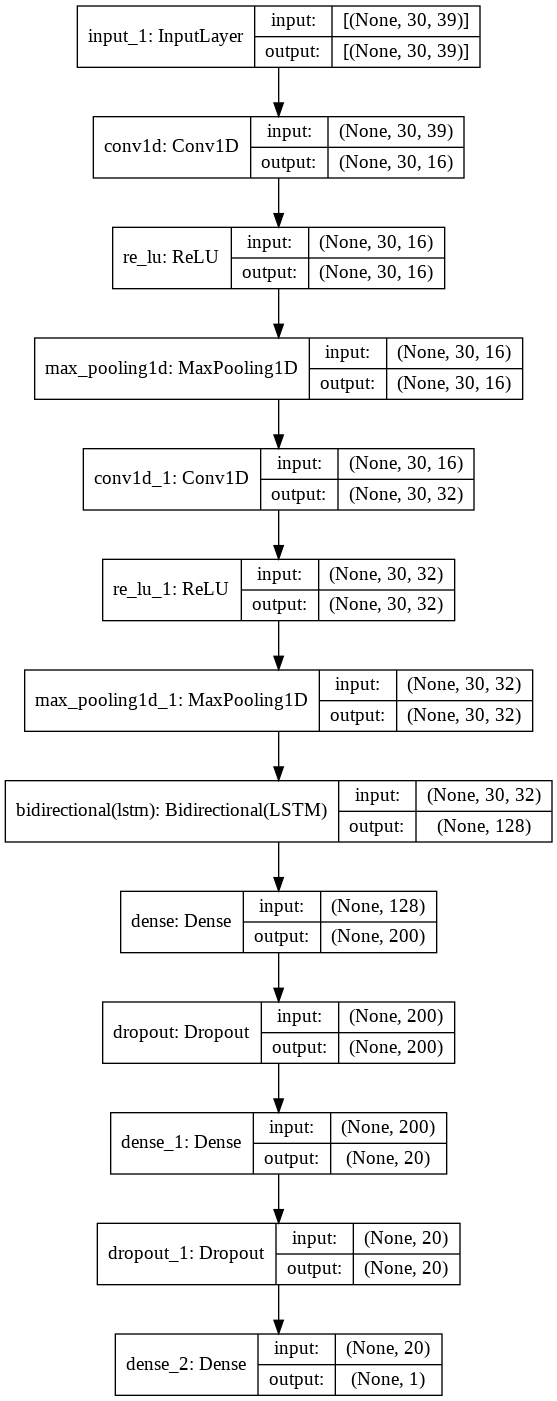

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse',metrics=[tf.keras.metrics.MeanSquaredError()])

In [22]:
#over_fitting after 30 epochs
model.fit(x=X2_train, y=Y_train['Y2'].values, validation_split=0.1, epochs=25, batch_size=128)

Epoch 1/25
678/678 [==============================] - 48s 23ms/step - loss: 21753.3340 - mean_squared_error: 21753.3340 - val_loss: 16384.7363 - val_mean_squared_error: 16384.7363
Epoch 2/25
678/678 [==============================] - 15s 22ms/step - loss: 18758.3809 - mean_squared_error: 18758.3809 - val_loss: 16188.6855 - val_mean_squared_error: 16188.6855
Epoch 3/25
678/678 [==============================] - 15s 22ms/step - loss: 18467.6816 - mean_squared_error: 18467.6816 - val_loss: 15212.6357 - val_mean_squared_error: 15212.6357
Epoch 4/25
678/678 [==============================] - 15s 22ms/step - loss: 18085.6855 - mean_squared_error: 18085.6855 - val_loss: 15083.2480 - val_mean_squared_error: 15083.2480
Epoch 5/25
678/678 [==============================] - 15s 21ms/step - loss: 17878.2480 - mean_squared_error: 17878.2480 - val_loss: 15064.9453 - val_mean_squared_error: 15064.9453
Epoch 6/25
678/678 [==============================] - 14s 21ms/step - loss: 17864.5918 - mean_square

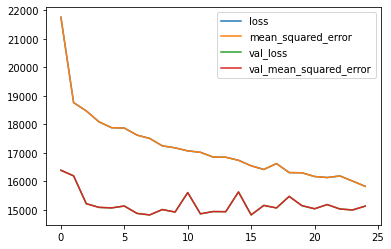

In [23]:
pd.DataFrame(model.history.history).plot()

In [24]:
predict_y2 = model.predict(X2_test)

In [25]:
predict_y2

array([[  8.124355],
       [ 78.35759 ],
       [ 74.38512 ],
       ...,
       [ 36.921547],
       [190.95468 ],
       [374.50494 ]], dtype=float32)

In [26]:
predict_y2.shape

(65242, 1)

# Simple Model

In [27]:
X1_train = X_train.groupby('UNIQUE_IDENTIFIER').mean()
X1_test = test_onehot.groupby('UNIQUE_IDENTIFIER').mean()

In [28]:
X1_train.head()

,SEQUENCE_NO,STATUS_CHECK,ACTIVE_YN,ENTRY,REVENUE,WINNINGS_1,WINNINGS_2,DISCOUNT,DEPOSIT,DEPOSIT_NUMBER,DEPOSIT_2,WITHDRAW,WITHDRAW_NUMBER,DEPOSIT_TRAILS,ENTRY_NUMBER,WINNINGS_NUMBER,PRACTICE_ENTRY,PRACTICE_WINNINGS,PRACTICE_ENTRY_NUMBER,PRACTICE_WINNINGS_NUMBER,CATEGORY_1_B,CATEGORY_1_C,CATEGORY_1_D,CATEGORY_1_E,CATEGORY_1_F,CATEGORY_1_G,CATEGORY_1_I,CATEGORY_1_J,CATEGORY_1_K,CATEGORY_1_L,CATEGORY_1_M,CATEGORY_2_B,CATEGORY_2_C,CATEGORY_2_D,CATEGORY_2_E,CATEGORY_2_F,CATEGORY_2_G,CATEGORY_2_H,CATEGORY_2_I
UNIQUE_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98481267304,4.0,0.0,1.000000,0.112236,0.008682,0.052929,0.0,0.000000,0.035714,0.014286,0.035714,0.000000,0.000000,0.000000,0.928571,0.442857,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
98481267698,10.0,1.0,0.947368,30.285742,3.733455,25.120618,0.0,1.163158,10.263158,0.052632,0.526316,1.357895,0.010526,0.684211,0.700000,0.247368,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
98481269325,9.5,0.0,1.000000,0.083720,0.007540,0.052828,0.0,0.033333,0.013889,0.005556,0.013889,0.000000,0.000000,0.027778,1.311111,0.305556,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
98481271512,3.0,0.0,1.000000,0.777000,0.122220,0.017000,0.0,0.240000,0.700000,0.040000,0.200000,0.000000,0.000000,0.540000,0.900000,0.040000,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
98481273023,1.0,0.0,1.000000,0.500000,0.080000,0.000000,0.0,0.000000,0.500000,0.100000,0.500000,0.000000,0.000000,0.000000,0.200000,0.000000,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [29]:
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1_train)
X1_test_scaled = scaler1.transform(X1_test)

In [30]:
input1 = tfl.Input(shape=(X1_scaled.shape[1]))
#1st layer
x = tfl.Dense(256, kernel_initializer="glorot_normal", kernel_regularizer="l2")(input1)
x = tfl.BatchNormalization()(x)
x = tfl.ELU(alpha=1)(x)
x = tfl.Dropout(0.5)(x)

# 2nd layer
x = tfl.Dense(128, kernel_initializer="glorot_normal", kernel_regularizer="l2")(x)
x = tfl.BatchNormalization()(x)
x = tfl.ELU(alpha=1)(x)
x = tfl.Dropout(0.5)(x)

# # 3rd layer
# x = tfl.Dense(64, kernel_initializer="glorot_normal", kernel_regularizer="l2")(x)
# x = tfl.BatchNormalization()(x)
# x = tfl.ELU(alpha=1)(x)

# #4th layer
# x = tfl.Dense(32, kernel_initializer="glorot_normal", kernel_regularizer="l2")(x)
# x = tfl.BatchNormalization()(x)
# x = tfl.ELU(alpha=1)(x)

# 5th layer
output1 = tfl.Dense(1, kernel_initializer="glorot_normal", kernel_regularizer="l2")(x)

model1 = tf.keras.Model(inputs=input1, outputs=output1)

In [31]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse")

In [32]:
model1.fit(x=X1_scaled, y=Y_train['Y1'].values, epochs=100, batch_size=512, validation_split=0.1)

Epoch 1/100
170/170 [==============================] - 2s 6ms/step - loss: 94.0625 - val_loss: 101.9454
Epoch 2/100
170/170 [==============================] - 1s 5ms/step - loss: 83.4638 - val_loss: 92.3889
Epoch 3/100
170/170 [==============================] - 1s 5ms/step - loss: 76.6696 - val_loss: 86.3388
Epoch 4/100
170/170 [==============================] - 1s 5ms/step - loss: 72.8523 - val_loss: 81.6360
Epoch 5/100
170/170 [==============================] - 1s 5ms/step - loss: 68.7738 - val_loss: 77.6942
Epoch 6/100
170/170 [==============================] - 1s 5ms/step - loss: 65.3674 - val_loss: 74.2461
Epoch 7/100
170/170 [==============================] - 1s 5ms/step - loss: 62.3842 - val_loss: 71.5178
Epoch 8/100
170/170 [==============================] - 1s 5ms/step - loss: 60.6828 - val_loss: 68.8069
Epoch 9/100
170/170 [==============================] - 1s 5ms/step - loss: 58.4525 - val_loss: 66.6117
Epoch 10/100
170/170 [==============================] - 1s 5ms/step - lo

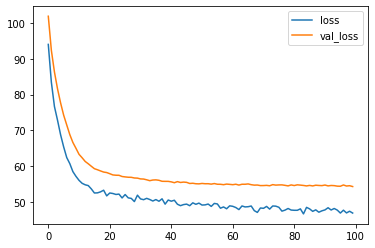

In [33]:
pd.DataFrame(model1.history.history).plot()

In [34]:
predict_y1 = model1.predict(X1_test_scaled)

In [35]:
predict_y1

array([[1.5880338],
       [4.169469 ],
       [2.9566438],
       ...,
       [2.1474123],
       [4.1173677],
       [6.3594995]], dtype=float32)

In [36]:
customer_index = test_onehot['UNIQUE_IDENTIFIER'].unique()

In [37]:
customer_index = np.expand_dims(customer_index, axis=1)

In [38]:
customer_index

array([[98481269471],
       [98481270499],
       [98481272694],
       ...,
       [98537204881],
       [98537205013],
       [98537205065]])

In [39]:
predictions = pd.DataFrame(np.hstack((customer_index, predict_y1, predict_y2)), columns=['UNIQUE_IDENTIFIER', 'Y1', 'Y2'])

In [40]:
predictions

,UNIQUE_IDENTIFIER,Y1,Y2
0,9.848127e+10,1.588034,8.124355
1,9.848127e+10,4.169469,78.357590
2,9.848127e+10,2.956644,74.385117
3,9.848127e+10,4.069886,151.369019
4,9.848128e+10,2.839535,33.403427
...,...,...,...
65237,9.853720e+10,5.191697,397.785187
65238,9.853720e+10,3.040583,5.436234
65239,9.853720e+10,2.147412,36.921547
65240,9.853721e+10,4.117368,190.954681


In [41]:
predictions['UNIQUE_IDENTIFIER'] = predictions['UNIQUE_IDENTIFIER'].astype("int64")

In [42]:
predictions

,UNIQUE_IDENTIFIER,Y1,Y2
0,98481269471,1.588034,8.124355
1,98481270499,4.169469,78.357590
2,98481272694,2.956644,74.385117
3,98481273365,4.069886,151.369019
4,98481278321,2.839535,33.403427
...,...,...,...
65237,98537204815,5.191697,397.785187
65238,98537204877,3.040583,5.436234
65239,98537204881,2.147412,36.921547
65240,98537205013,4.117368,190.954681


In [48]:
predict=pd.DataFrame(model.predict(X2_train))
predict1=pd.DataFrame(model1.predict(X1_scaled))
pred=pd.concat([predict, predict1], axis=1)
exact=pd.DataFrame(pred)

from sklearn.metrics import mean_squared_error
m1 = np.sqrt(mean_squared_error(Y_train.iloc[:,1],exact.iloc[:,0]))
m2 = np.sqrt(mean_squared_error(Y_train.iloc[:,0],exact.iloc[:,1]))
print((m1+m2)/2)

61.68752353976654


In [50]:
predictions.to_csv("1D_Bi_LSTM_61_modified.csv", index=False)